## A simple model - using the market and news data

In [1]:
# Will reduce data load for code test
toy = False

In [2]:
from kaggle.competitions import twosigmanews
# You can only call make_env() once, so don't lose it!
env = twosigmanews.make_env()
print('Done!')

Loading the data... This could take a minute.
Done!
Done!


In [3]:
(market_train_df, news_train_df) = env.get_training_data()

In [4]:
market_train_df.shape, news_train_df.shape

((4072956, 16), (9328750, 35))

In [5]:
# We will reduce the number of samples for memory reasons
if toy:
    market_train_df = market_train_df.tail(100_000)
    news_train_df = news_train_df.tail(300_000)
else:
    market_train_df = market_train_df.tail(3_000_000)
    news_train_df = news_train_df.tail(6_000_000)

In [6]:
import lightgbm as lgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import chain

%matplotlib inline

In [7]:
news_cols_agg = {
    'urgency': ['min', 'count'],
    'takeSequence': ['max'],
    'bodySize': ['min', 'max', 'mean', 'std'],
    'wordCount': ['min', 'max', 'mean', 'std'],
    'sentenceCount': ['min', 'max', 'mean', 'std'],
    'companyCount': ['min', 'max', 'mean', 'std'],
    'marketCommentary': ['min', 'max', 'mean', 'std'],
    'relevance': ['min', 'max', 'mean', 'std'],
    'sentimentNegative': ['min', 'max', 'mean', 'std'],
    'sentimentNeutral': ['min', 'max', 'mean', 'std'],
    'sentimentPositive': ['min', 'max', 'mean', 'std'],
    'sentimentWordCount': ['min', 'max', 'mean', 'std'],
    'noveltyCount12H': ['min', 'max', 'mean', 'std'],
    'noveltyCount24H': ['min', 'max', 'mean', 'std'],
    'noveltyCount3D': ['min', 'max', 'mean', 'std'],
    'noveltyCount5D': ['min', 'max', 'mean', 'std'],
    'noveltyCount7D': ['min', 'max', 'mean', 'std'],
    'volumeCounts12H': ['min', 'max', 'mean', 'std'],
    'volumeCounts24H': ['min', 'max', 'mean', 'std'],
    'volumeCounts3D': ['min', 'max', 'mean', 'std'],
    'volumeCounts5D': ['min', 'max', 'mean', 'std'],
    'volumeCounts7D': ['min', 'max', 'mean', 'std']
}

In [8]:
def join_market_news(market_train_df, news_train_df):
    # Fix asset codes (str -> list)
    news_train_df['assetCodes'] = news_train_df['assetCodes'].str.findall(f"'([\w\./]+)'")    
    
    # Expand assetCodes
    assetCodes_expanded = list(chain(*news_train_df['assetCodes']))
    assetCodes_index = news_train_df.index.repeat( news_train_df['assetCodes'].apply(len) )

    assert len(assetCodes_index) == len(assetCodes_expanded)
    df_assetCodes = pd.DataFrame({'level_0': assetCodes_index, 'assetCode': assetCodes_expanded})

    # Create expandaded news (will repeat every assetCodes' row)
    news_cols = ['time', 'assetCodes'] + sorted(news_cols_agg.keys())
    news_train_df_expanded = pd.merge(df_assetCodes, news_train_df[news_cols], left_on='level_0', right_index=True, suffixes=(['','_old']))

    # Free memory
    del news_train_df, df_assetCodes

    # Aggregate numerical news features
    news_train_df_aggregated = news_train_df_expanded.groupby(['time', 'assetCode']).agg(news_cols_agg)
    
    # Free memory
    del news_train_df_expanded

    # Convert to float32 to save memory
    news_train_df_aggregated = news_train_df_aggregated.apply(np.float32)

    # Flat columns
    news_train_df_aggregated.columns = ['_'.join(col).strip() for col in news_train_df_aggregated.columns.values]

    # Join with train
    market_train_df = market_train_df.join(news_train_df_aggregated, on=['time', 'assetCode'])

    # Free memory
    del news_train_df_aggregated
    
    return market_train_df

In [9]:
def get_xy(market_train_df, news_train_df, le=None):
    x, le = get_x(market_train_df, news_train_df)
    y = market_train_df['returnsOpenNextMktres10'].clip(-1, 1)
    return x, y, le


def label_encode(series, min_count):
    vc = series.value_counts()
    le = {c:i for i, c in enumerate(vc.index[vc >= min_count])}
    return le


def get_x(market_train_df, news_train_df, le=None):
    # Split date into before and after 22h (the time used in train data)
    # E.g: 2007-03-07 23:26:39+00:00 -> 2007-03-08 00:00:00+00:00 (next day)
    #      2009-02-25 21:00:50+00:00 -> 2009-02-25 00:00:00+00:00 (current day)
    news_train_df['time'] = (news_train_df['time'] - np.timedelta64(22,'h')).dt.ceil('1D')

    # Round time of market_train_df to 0h of curret day
    market_train_df['time'] = market_train_df['time'].dt.floor('1D')

    # Join market and news
    x = join_market_news(market_train_df, news_train_df)
    
    # If not label-encoder... encode assetCode
    if le is None:
        le_assetCode = label_encode(x['assetCode'], min_count=10)
        le_assetName = label_encode(x['assetName'], min_count=5)
    else:
        # 'unpack' label encoders
        le_assetCode, le_assetName = le
        
    x['assetCode'] = x['assetCode'].map(le_assetCode).fillna(-1).astype(int)
    x['assetName'] = x['assetName'].map(le_assetName).fillna(-1).astype(int)
    
    try:
        x.drop(columns=['returnsOpenNextMktres10'], inplace=True)
    except:
        pass
    try:
        x.drop(columns=['universe'], inplace=True)
    except:
        pass
    x['dayofweek'], x['month'] = x.time.dt.dayofweek, x.time.dt.month
    x.drop(columns='time', inplace=True)
#    x.fillna(-1000,inplace=True)

    # Fix some mixed-type columns
    for bogus_col in ['marketCommentary_min', 'marketCommentary_max']:
        x[bogus_col] = x[bogus_col].astype(float)
    
    return x, (le_assetCode, le_assetName)

In [10]:
%%time

# This will take some time...
X, y, le = get_xy(market_train_df, news_train_df)

CPU times: user 43.9 s, sys: 23.8 s, total: 1min 7s
Wall time: 1min 7s


In [11]:
X.shape, y.shape

((3000000, 98), (3000000,))

In [12]:
# Save universe data for latter use
universe = market_train_df['universe']
time = market_train_df['time']

# Free memory
del market_train_df, news_train_df

In [13]:
X_ = X

In [14]:
# Keep only text columns
X = X_#.iloc[:, X.columns.get_loc('urgency_min'):X.columns.get_loc('dayofweek')]

In [15]:
X.tail()

,assetCode,assetName,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,urgency_min,urgency_count,takeSequence_max,bodySize_min,bodySize_max,bodySize_mean,bodySize_std,wordCount_min,wordCount_max,wordCount_mean,wordCount_std,sentenceCount_min,sentenceCount_max,sentenceCount_mean,sentenceCount_std,companyCount_min,companyCount_max,companyCount_mean,companyCount_std,marketCommentary_min,marketCommentary_max,marketCommentary_mean,marketCommentary_std,relevance_min,relevance_max,relevance_mean,relevance_std,...,noveltyCount12H_mean,noveltyCount12H_std,noveltyCount24H_min,noveltyCount24H_max,noveltyCount24H_mean,noveltyCount24H_std,noveltyCount3D_min,noveltyCount3D_max,noveltyCount3D_mean,noveltyCount3D_std,noveltyCount5D_min,noveltyCount5D_max,noveltyCount5D_mean,noveltyCount5D_std,noveltyCount7D_min,noveltyCount7D_max,noveltyCount7D_mean,noveltyCount7D_std,volumeCounts12H_min,volumeCounts12H_max,volumeCounts12H_mean,volumeCounts12H_std,volumeCounts24H_min,volumeCounts24H_max,volumeCounts24H_mean,volumeCounts24H_std,volumeCounts3D_min,volumeCounts3D_max,volumeCounts3D_mean,volumeCounts3D_std,volumeCounts5D_min,volumeCounts5D_max,volumeCounts5D_mean,volumeCounts5D_std,volumeCounts7D_min,volumeCounts7D_max,volumeCounts7D_mean,volumeCounts7D_std,dayofweek,month
4072951,2112,2061,1608829.0,5.35,5.37,-0.003724,0.000000,0.000536,-0.001868,-0.165367,-0.138042,-0.139597,-0.135913,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,12
4072952,1991,1952,347830.0,43.52,43.62,-0.000689,0.000000,-0.000515,0.000493,0.002996,0.002989,0.008213,0.003210,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,12
4072953,1240,1267,7396601.0,2.57,2.58,-0.011538,0.000000,-0.006004,-0.001034,-0.091873,-0.078571,-0.077252,-0.077188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,12
4072954,3239,0,3146519.0,12.07,12.50,-0.029743,0.007252,-0.028460,0.006719,-0.065066,-0.042146,-0.078104,-0.043813,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,12
4072955,1512,1513,1701204.0,53.53,53.64,-0.001678,0.003091,0.005060,0.002885,0.023127,0.028177,0.026566,0.028719,3.0,1.0,1.0,4951.0,4951.0,4951.0,NaN,834.0,834.0,834.0,NaN,27.0,27.0,27.0,NaN,1.0,1.0,1.0,NaN,0.0,0.0,0.0,NaN,1.0,1.0,1.0,NaN,...,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,4,12


In [16]:
n_train = int(X.shape[0] * 0.8)

X_train, y_train = X.iloc[:n_train], y.iloc[:n_train]
X_valid, y_valid = X.iloc[n_train:], y.iloc[n_train:]

In [17]:
# For valid data, keep only those with universe > 0. This will help calculate the metric
u_valid = (universe.iloc[n_train:] > 0)
t_valid = time.iloc[n_train:]

X_valid = X_valid[u_valid]
y_valid = y_valid[u_valid]
t_valid = t_valid[u_valid]
del u_valid

In [18]:
# Creat lgb datasets
train_cols = X.columns.tolist()
categorical_cols = [] # ['assetCode', 'assetName', 'dayofweek', 'month']

# Note: y data is expected to be a pandas Series, as we will use its group_by function in `sigma_score`
dtrain = lgb.Dataset(X_train.values, y_train, feature_name=train_cols, categorical_feature=categorical_cols, free_raw_data=False)
dvalid = lgb.Dataset(X_valid.values, y_valid, feature_name=train_cols, categorical_feature=categorical_cols, free_raw_data=False)

In [19]:
# We will 'inject' an extra parameter in order to have access to df_valid['time'] inside sigma_score without globals
dvalid.params = {
    'extra_time': t_valid.factorize()[0]
}

In [20]:
lgb_params = dict(
    objective = 'regression_l1',
    learning_rate = 0.1,
    num_leaves = 127,
    max_depth = -1,
#     min_data_in_leaf = 1000,
#     min_sum_hessian_in_leaf = 10,
    bagging_fraction = 0.75,
    bagging_freq = 2,
    feature_fraction = 0.5,
    lambda_l1 = 0.0,
    lambda_l2 = 1.0,
    metric = 'None', # This will ignore the loss objetive and use sigma_score instead,
    seed = 42 # Change for better luck! :)
)

def sigma_score(preds, valid_data):
    df_time = valid_data.params['extra_time']
    labels = valid_data.get_label()
    
#    assert len(labels) == len(df_time)

    x_t = preds * labels #  * df_valid['universe'] -> Here we take out the 'universe' term because we already keep only those equals to 1.
    
    # Here we take advantage of the fact that `labels` (used to calculate `x_t`)
    # is a pd.Series and call `group_by`
    x_t_sum = x_t.groupby(df_time).sum()
    score = x_t_sum.mean() / x_t_sum.std()

    return 'sigma_score', score, True

evals_result = {}
m = lgb.train(lgb_params, dtrain, num_boost_round=1000, valid_sets=(dvalid,), valid_names=('valid',), verbose_eval=25,
              early_stopping_rounds=100, feval=sigma_score, evals_result=evals_result)


df_result = pd.DataFrame(evals_result['valid'])

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 100 rounds.
[25]	valid's sigma_score: 0.450095
[50]	valid's sigma_score: 0.458712
[75]	valid's sigma_score: 0.45635
[100]	valid's sigma_score: 0.463579
[125]	valid's sigma_score: 0.462978
[150]	valid's sigma_score: 0.459344
[175]	valid's sigma_score: 0.457493
[200]	valid's sigma_score: 0.46057
Early stopping, best iteration is:
[112]	valid's sigma_score: 0.46481


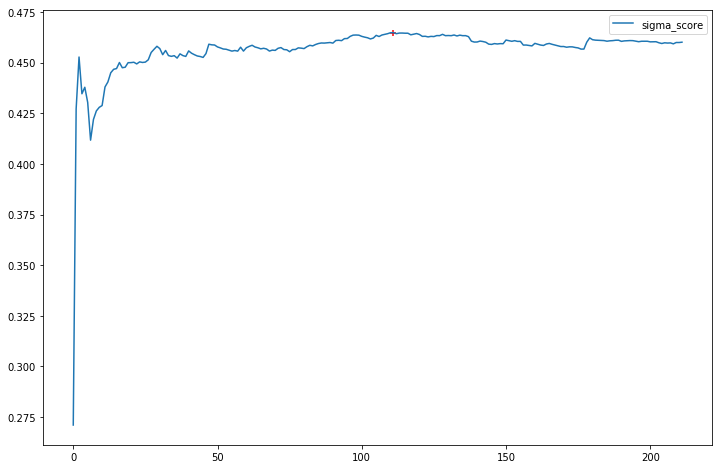

In [21]:
ax = df_result.plot(figsize=(12, 8))
ax.scatter(df_result['sigma_score'].idxmax(), df_result['sigma_score'].max(), marker='+', color='red')

In [22]:
num_boost_round, valid_score = df_result['sigma_score'].idxmax()+1, df_result['sigma_score'].max()
print(lgb_params)
print(f'Best score was {valid_score:.5f} on round {num_boost_round}')

{'objective': 'regression_l1', 'learning_rate': 0.1, 'num_leaves': 127, 'max_depth': -1, 'bagging_fraction': 0.75, 'bagging_freq': 2, 'feature_fraction': 0.5, 'lambda_l1': 0.0, 'lambda_l2': 1.0, 'metric': 'None', 'seed': 42, 'verbose': 1}
Best score was 0.46481 on round 112


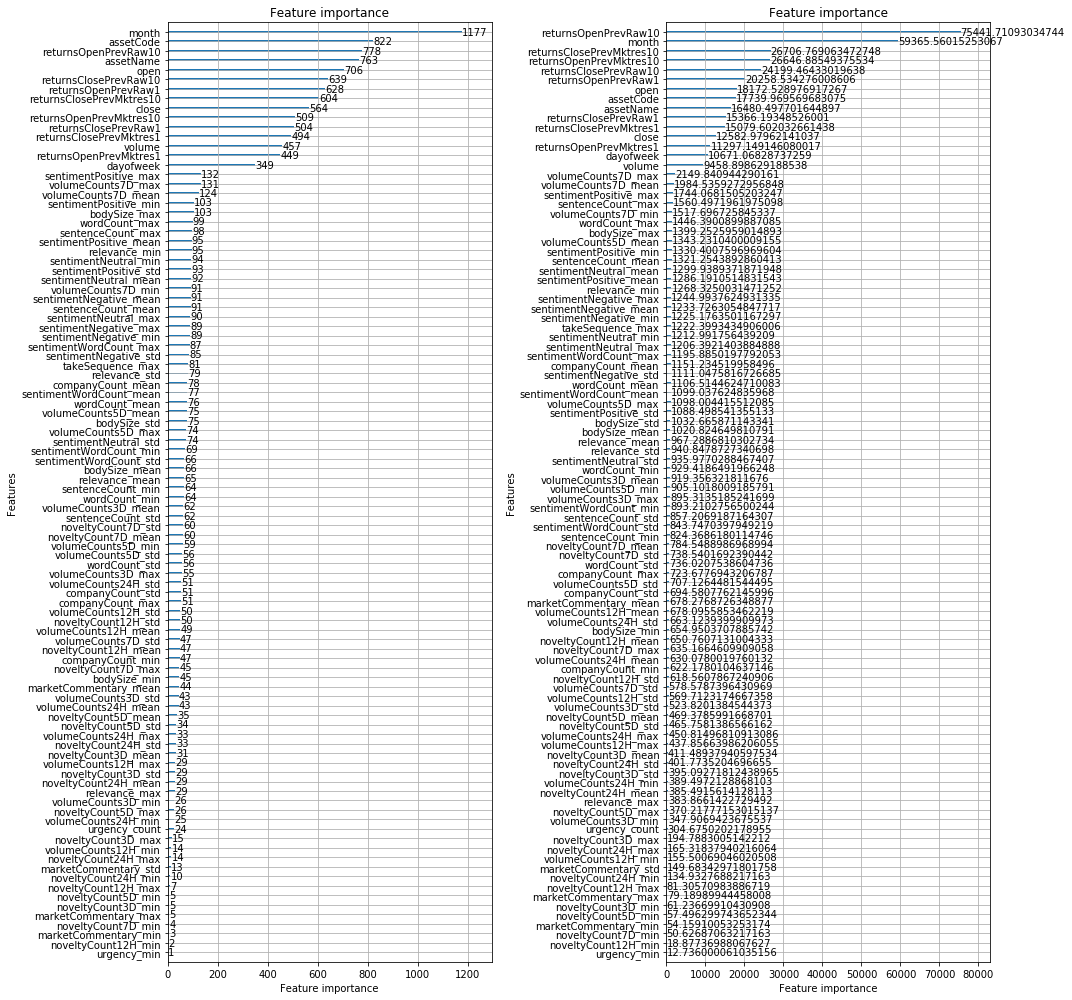

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(14, 14))
lgb.plot_importance(m, ax=ax[0])
lgb.plot_importance(m, ax=ax[1], importance_type='gain')
fig.tight_layout()

# Train full model
Now we train a full model with `num_boost_round` found in validation.

In [24]:
# Train full model
dtrain_full = lgb.Dataset(X, y, feature_name=train_cols, categorical_feature=categorical_cols)

model = lgb.train(lgb_params, dtrain, num_boost_round=num_boost_round)

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


In [25]:
def make_predictions(predictions_template_df, market_obs_df, news_obs_df, le):
    x, _ = get_x(market_obs_df, news_obs_df, le)
    predictions_template_df.confidenceValue = np.clip(model.predict(x), -1, 1)

In [26]:
days = env.get_prediction_days()

for (market_obs_df, news_obs_df, predictions_template_df) in days:
    make_predictions(predictions_template_df, market_obs_df, news_obs_df, le)
    env.predict(predictions_template_df)
print('Done!')

Done!


In [27]:
env.write_submission_file()

Your submission file has been saved. Once you `Commit` your Kernel and it finishes running, you can submit the file to the competition from the Kernel Viewer `Output` tab.
